# Diabetes Patients Early Readmissions Prediction

**Authors:** [Peter Macinec](https://github.com/pmacinec), [Frantisek Sefcik](https://github.com/FrantisekSefcik)

## Evaluation

In this jupyter notebook, we evaluate our model for diabetes patients early readmission prediction.

### Setup and import libraries

In [1]:
# Automatically reloading imported modules
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

# Supress libraries deprecation import warnings
import warnings
warnings.filterwarnings('ignore')

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, auc
from pprint import pprint

from src.preprocessing.helpers import describe_dataset
from src.evaluation import *

### Load train and test data

In [4]:
X_train = pd.read_csv('../data/X_train.csv')
X_test = pd.read_csv('../data/X_test.csv')
y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

In [5]:
describe_dataset(X_train, X_test, y_train, y_test)

Number of train data: 81409
Number of test data: 20353
Number of features: 58
Classes:
	0 :
	    train: 72315 samples, 89.0%
	    test: 18090 samples, 89.0%

	1 :
	    train: 9094 samples, 11.0%
	    test: 2263 samples, 11.0%



### Data balancing

#### Undersampling with NearMiss

In [6]:
X_train_undersampled, y_train_undersampled = undersample(X_train, y_train)

In [7]:
len(X_train_undersampled), len(y_train_undersampled)

(18188, 18188)

#### Oversampling with SMOTE

In [8]:
X_train_oversampled, y_train_oversampled = oversample(X_train, y_train)

In [9]:
len(X_train_oversampled), len(y_train_oversampled)

(144630, 144630)

### Random search

#### We define set of parameters for Random forest  

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 60, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [5, 10, 16, 21, 27, 32, 38, 43, 49, 54, 60, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


#### Initialize and  run random search

In [20]:
rf = RandomForestClassifier(class_weight={0:1,1:9})
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring = "roc_auc",
                               n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = 10)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  27 out of  30 | elapsed:  3.9min remaining:   26.0s
[Parallel(n_jobs=10)]: Done  30 out of  30 | elapsed:  4.1min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight={0: 1, 1: 9},
                                                    criterion='gini',
                                                    max_depth=10,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=5,
                                                    min_weight_fraction_leaf=0.0,
         

##### The best score and params obtained with

In [21]:
rf_random.best_score_

0.6467207715893863

In [22]:
rf_random.best_params_

{'n_estimators': 560,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 54,
 'bootstrap': True}

##### Control best model on test data

In [23]:
best_random = rf_random.best_estimator_

              precision    recall  f1-score   support

           0       0.89      0.98      0.93     18090
           1       0.30      0.08      0.12      2263

    accuracy                           0.88     20353
   macro avg       0.60      0.53      0.53     20353
weighted avg       0.83      0.88      0.84     20353

ROC AUC score: 0.53


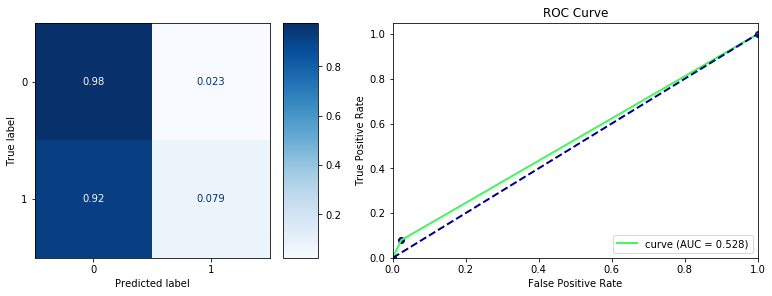

In [25]:
evaluate_model(best_random, X_test, y_test)

### Feature selection

              precision    recall  f1-score   support

           0       0.93      0.60      0.73     18090
           1       0.16      0.62      0.26      2263

    accuracy                           0.60     20353
   macro avg       0.54      0.61      0.49     20353
weighted avg       0.84      0.60      0.67     20353

ROC AUC score: 0.61


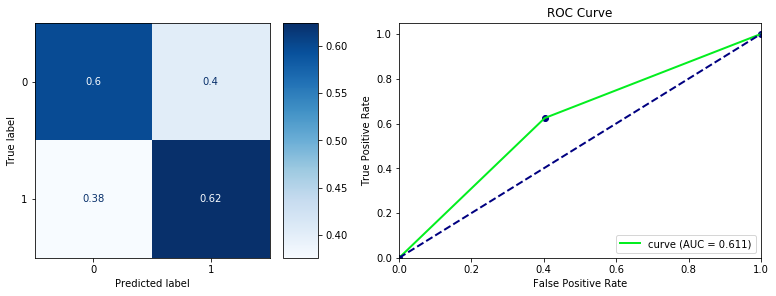

In [39]:
rf = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100
                             ,class_weight={0:1,1:9}, min_samples_split=5
                            )
rf.fit(X_train, y_train)
evaluate_model(rf, X_test, y_test)

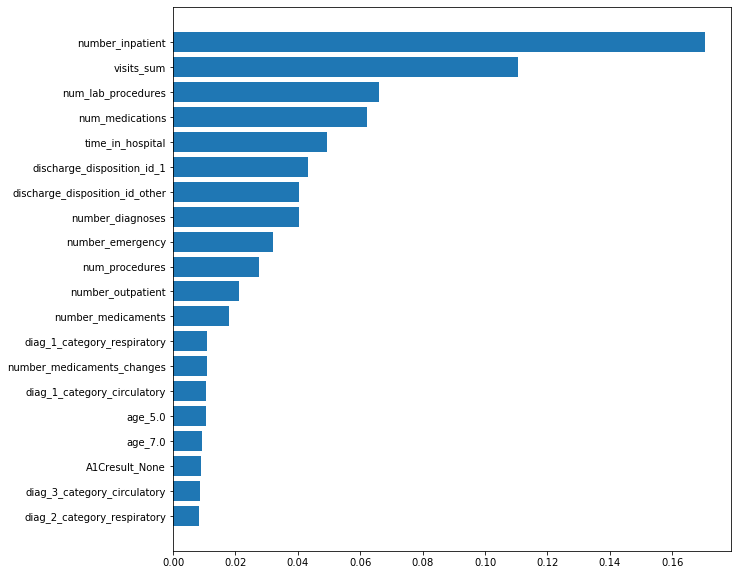

In [47]:
sorted_features = plot_feature_importance(rf.feature_importances_, X_train.columns, 20)

In [55]:
for x in range(5, 58, 3):
    rf = RandomForestClassifier(max_depth=10, random_state=42, n_estimators=100,class_weight={0:1,1:9}, min_samples_split=5)
    rf.fit(X_train[sorted_features[:x]], y_train)
    y_pred = rf.predict(X_test[sorted_features[:x]])
    prob = y_pred / y_pred.max()
    fpr, tpr, _ = roc_curve(y_test, prob, drop_intermediate=True)
    auc_value = auc(fpr, tpr)
    print(f"Num. of features: {x}, ROC AUC: {auc_value}")
    

Num. of features: 5, ROC AUC: 0.592238261239587
Num. of features: 8, ROC AUC: 0.5985937646182599
Num. of features: 11, ROC AUC: 0.5979887717107495
Num. of features: 14, ROC AUC: 0.6032650246093635
Num. of features: 17, ROC AUC: 0.6056720619419718
Num. of features: 20, ROC AUC: 0.600477701833055
Num. of features: 23, ROC AUC: 0.6055350609841743
Num. of features: 26, ROC AUC: 0.6014759755501473
Num. of features: 29, ROC AUC: 0.6087965314098238
Num. of features: 32, ROC AUC: 0.6045978801431542
Num. of features: 35, ROC AUC: 0.6061987528845681
Num. of features: 38, ROC AUC: 0.6078600345354291
Num. of features: 41, ROC AUC: 0.609625547814519
Num. of features: 44, ROC AUC: 0.6076668994595931
Num. of features: 47, ROC AUC: 0.6057597684479844
Num. of features: 50, ROC AUC: 0.6097949761185725
Num. of features: 53, ROC AUC: 0.606589981794274
Num. of features: 56, ROC AUC: 0.6066450899623744
